In [1]:
import os
import json
import logging

#Libraries from PyTorch
from torchvision.io import read_image
import torch  # PyTorch's core library for building and training deep learning models
import torch.nn as nn  # Import the neural network module from PyTorch
import torch.optim as optim  # Import optimization algorithms such as SGD, Adam
import torch.nn.functional as F  # Import functional utilities like activation functions
from torch.utils.data import Dataset, DataLoader, random_split # DataLoader for batching, and random_split for splitting data
from torchvision import datasets, models, transforms
from torchvision.models import ResNet50_Weights
from torchvision.models import resnet50
from pycocotools.coco import COCO # type: ignore
from torch.nn.utils.rnn import pad_sequence

#Libraries for data processing and visualization
from matplotlib import pyplot as plt # For plotting graphs
import matplotlib.patches as patches # For bounding boxes
import numpy as np # For numerical operations
from PIL import Image
from collections import defaultdict

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix  # For evaluation metrics

plt.rcParams['figure.figsize'] = (15, 15)

import pandas as pd
import seaborn as sn


In [2]:
image_ids_annotations = defaultdict(list)

# Load annotations
path = './annotations/instances_train2017_mod.json'
file = open(path)
anns = json.load(file)
image_ids = list()

# Add into datastructure
for ann in anns['annotations']:
    image_id = ann['image_id'] # Are integers
    image_ids.append(image_id)
    image_ids_annotations[image_id].append(ann)


In [3]:
# Inicialization of the values per categorie  
catergory_id_count = dict()
contador = list(range(1,81))
for a in contador:
    catergory_id_count[a] = 0

# Identification of the repetion per category 
for ann in anns['annotations']:
    category_id = ann['category_id']
    catergory_id_count[category_id] += 1

print(catergory_id_count)


{1: 262465, 2: 7113, 3: 43867, 4: 8725, 5: 5135, 6: 6069, 7: 4571, 8: 9973, 9: 10759, 10: 12884, 11: 1865, 12: 1983, 13: 1285, 14: 9838, 15: 10806, 16: 4768, 17: 5508, 18: 6587, 19: 9509, 20: 8147, 21: 5513, 22: 1294, 23: 5303, 24: 5131, 25: 8720, 26: 11431, 27: 12354, 28: 6496, 29: 6192, 30: 2682, 31: 6646, 32: 2685, 33: 6347, 34: 9076, 35: 3276, 36: 3747, 37: 5543, 38: 6126, 39: 4812, 40: 24342, 41: 7913, 42: 20650, 43: 5479, 44: 7770, 45: 6165, 46: 14358, 47: 9458, 48: 5851, 49: 4373, 50: 6399, 51: 7308, 52: 7852, 53: 2918, 54: 5821, 55: 7179, 56: 6353, 57: 38491, 58: 5779, 59: 8652, 60: 4192, 61: 15714, 62: 4157, 63: 5805, 64: 4970, 65: 2262, 66: 5703, 67: 2855, 68: 6434, 69: 1673, 70: 3334, 71: 225, 72: 5610, 73: 2637, 74: 24715, 75: 6334, 76: 6613, 77: 1481, 78: 4793, 79: 198, 80: 1954}


In [4]:
# Get mapping category_id to category name
catergory_id_to_name = dict()

for index, cat in enumerate(anns['categories']):
    catergory_id_to_name[cat['id']] = cat['name']

print(anns['categories'])
print(catergory_id_count)
print(catergory_id_to_name)

[{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}, {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}, {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}, {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}, {'supercategory': 'outdoor', 'id': 12, 'name': 'stop sign'}, {'supercategory': 'outdoor', 'id': 13, 'name': 'parking meter'}, {'supercategory': 'outdoor', 'id': 14, 'name': 'bench'}, {'supercategory': 'animal', 'id': 15, 'name': 'bird'}, {'supercategory': 'animal', 'id': 16, 'name': 'cat'}, {'supercategory': 'animal', 'id': 17, 'name': 'dog'}, {'supercategory

80
80
[262465, 7113, 43867, 8725, 5135, 6069, 4571, 9973, 10759, 12884, 1865, 1983, 1285, 9838, 10806, 4768, 5508, 6587, 9509, 8147, 5513, 1294, 5303, 5131, 8720, 11431, 12354, 6496, 6192, 2682, 6646, 2685, 6347, 9076, 3276, 3747, 5543, 6126, 4812, 24342, 7913, 20650, 5479, 7770, 6165, 14358, 9458, 5851, 4373, 6399, 7308, 7852, 2918, 5821, 7179, 6353, 38491, 5779, 8652, 4192, 15714, 4157, 5805, 4970, 2262, 5703, 2855, 6434, 1673, 3334, 225, 5610, 2637, 24715, 6334, 6613, 1481, 4793, 198, 1954]


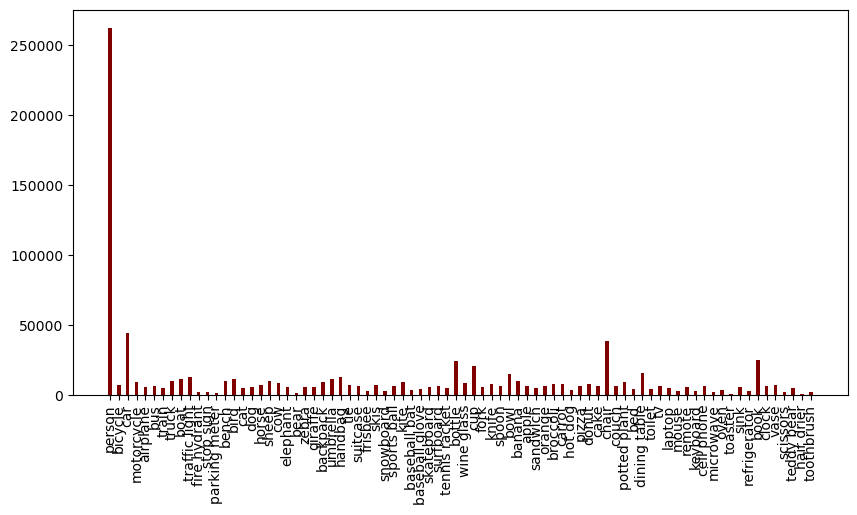

In [5]:
# Creation of the Histogram 
values = list(catergory_id_count.values())
classes = list(catergory_id_to_name.values())
print(len(values))
print(len(classes))

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(classes, values, color ='maroon', 
        width = 0.4)
plt.xticks(rotation=90)

print(values)

In [6]:
class CocoDetection(Dataset):
    """`MS Coco Detection <http://mscoco.org/dataset/#detections-challenge2016>`_ Dataset.

    Args:
        root (string): Root directory where images are downloaded to.
        annFile (string): Path to json annotation file.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.ToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """

    def __init__(self, root, annFile, transform=None, target_transform=None):
        self.root = root
        self.coco = COCO(annFile)
        self.ids = list(self.coco.imgs.keys())
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: Tuple (image, target). target is the object returned by ``coco.loadAnns``.
        """
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        target = coco.loadAnns(ann_ids)

        
        #print(ann_ids)
        #print(target)

        path = coco.loadImgs(img_id)[0]['file_name']

        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        labels = torch.zeros(80)

        for ann in target:
            category_id = ann['category_id']
            labels[category_id-1] = 1.0

        return img, labels


    def __len__(self):
        return len(self.ids)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str


In [7]:
# Resizing of Images and Normalization
img_dir = './train2017'

img_transforms = transforms.Compose([
        transforms.Resize((224, 224)), # Resize Images to a size of 24*24 Pixels
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]) # Normalization using standard values for RGB images
    ])

train_data = CocoDetection(root=img_dir,
                           annFile=path,
                            transform=img_transforms) 


loading annotations into memory...
Done (t=11.26s)
creating index...
index created!


In [8]:
train_size = int(0.8 * len(train_data))  # 90% of the data will be used for training
val_size = int(0.1 * len(train_data))  # 10% of the data  will be used for validation
test_size = len(train_data) - train_size - val_size # Remaining data will be used for test

train_data, val_data, test_data = random_split(train_data, [train_size, val_size, test_size]) # Divide dataset into training, validation and test splits. 

tensor([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
torch.Size([3, 224, 224])


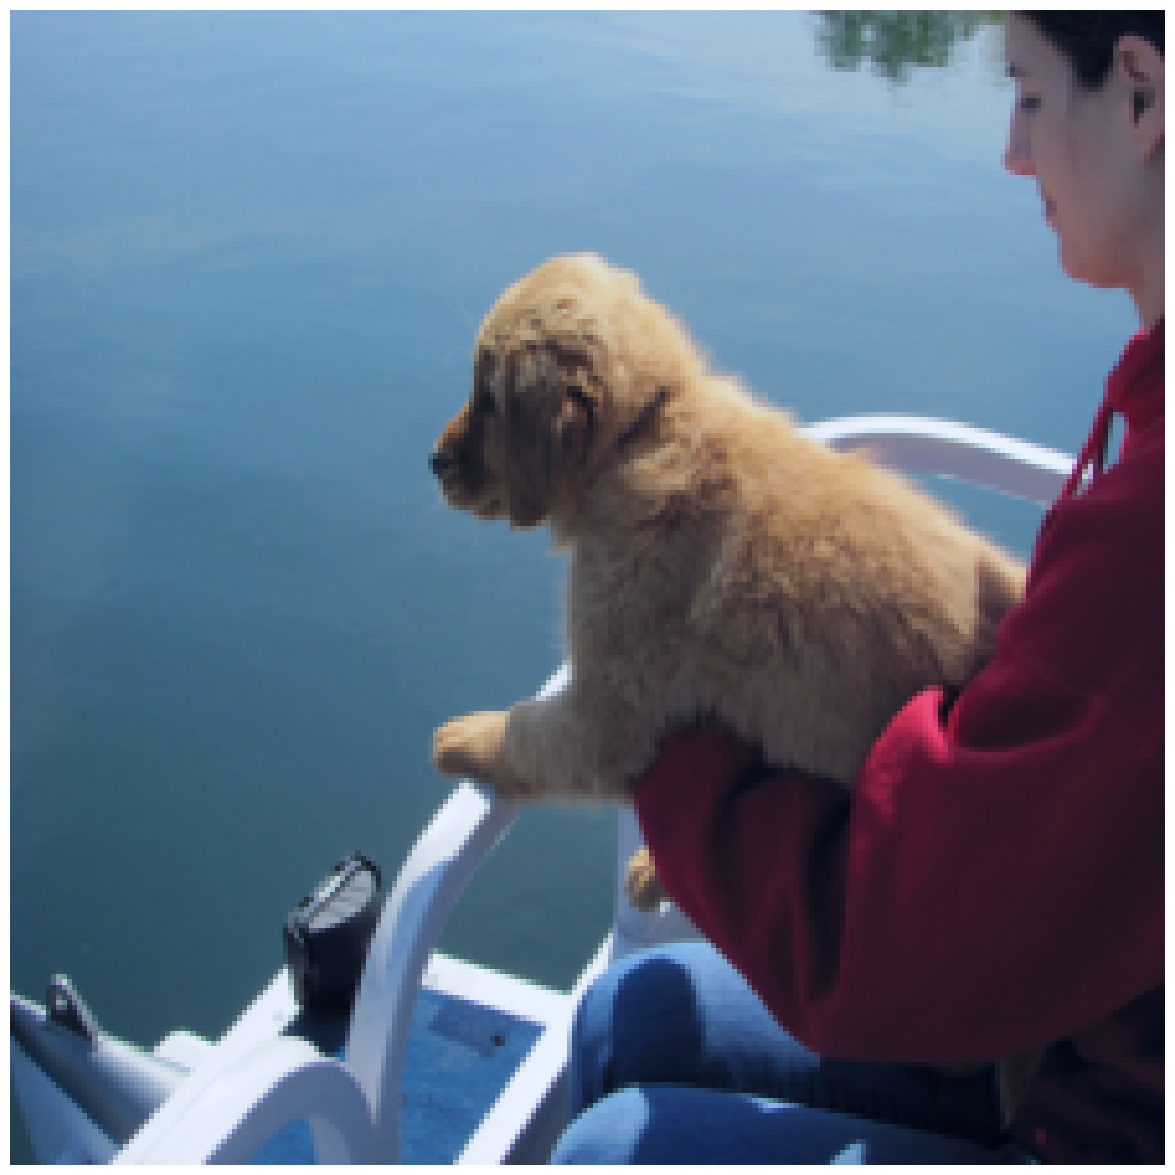

person
boat
dog


In [9]:
img_test, target_test = test_data.__getitem__(2)

print(target_test)
print(img_test.size())

# Convert the tensor to a numpy array and rearrange to [H, W, C] for matplotlib
image_numpy = img_test.permute(1, 2, 0).numpy()

# Normalize the values to be between 0 and 1 for proper visualization
# (this step assumes the tensor values are between -1 and 1, adjust as needed)
image_numpy = (image_numpy - image_numpy.min()) / (image_numpy.max() - image_numpy.min())

# Plot the image
plt.imshow(image_numpy)
plt.axis('off')  # Turn off axis
plt.show()

target_test = target_test.numpy()

for i in range(len(classes)):
    if target_test[i] == 1:
        print(classes[i])

In [10]:
# DataLoader for the training set
train_loader = DataLoader(
    train_data,  # The training dataset
    batch_size=16,  # Number of samples per batch during training
    shuffle=True,  # Shuffle the data at the start of every epoch for better generalization
)

# DataLoader for the validation set
val_loader = DataLoader(
    val_data,  # The validation dataset
    batch_size=16,  # Same batch size as training
    shuffle=False  # No need to shuffle validation data
)

# DataLoader for the validation set
test_loader = DataLoader(
    test_data,  # The validation dataset
    batch_size=1,  # Same batch size as training
    shuffle=False  # No need to shuffle validation data
)

# Printing of the sizes of the datasets
print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Test set size: {len(test_data)}")

Training set size: 94629
Validation set size: 11828
Test set size: 11830


In [11]:
# Check if CUDA (GPU support) is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Check if CUDA is available and output the result (True if a GPU is available, False otherwise)
torch.cuda.is_available()


False

In [12]:
# Define the OOP Model class inheriting from nn.Module
class CustomMLP(nn.Module):
    def __init__(self):
        super(CustomMLP, self).__init__()  # Call the parent class's constructor

        #First Layer
        self.fc1 = nn.Linear(224 * 224 *3 ,512) # Fully conected layer that takes 224*224*3Pixel input and maps it to 512 units.
        #Second Layer
        self.fc2 = nn.Linear(512,512) # Another fully conected layer that keeps the 512 units.
        #Output layer
        self.fc3 = nn.Linear(512,90) # Output layer that maps the 512 units to 80 units.

        # Define the activation function - ReLU (Rectified Linear Unit) - Sigmoid
        self.relu = nn.ReLU() # ReLU intriduces non-linearity after each layer
        self.sigmoid = nn.Sigmoid()


    # Define the forward pass (how data flows through the network)
    def forward(self, x):
        x = x.view(-1, 224 * 224 * 3) # Flatten the input tensor from 224*224*3 to 150528

        x = F.relu(self.fc1(x)) # Pass data through the first layer and apply ReLU activation 

        x = F.relu(self.fc2(x)) # Pass data through the second layer and apply ReLU activation

        return self.sigmoid(self.fc3(x)) # Pass data through the output layer and apply Sigmoid activation

In [13]:
# Instantiate the OOP model
oop_model = CustomMLP().to(device)  # Move the model to the device (GPU/CPU)

print(oop_model)

CustomMLP(
  (fc1): Linear(in_features=150528, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=90, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [14]:
# Define Loss function
loss_fn = nn.CrossEntropyLoss()
# Define Optimizer
optimizer = optim.Adam(oop_model.parameters(), lr=0.001)

In [12]:
# Modified training loop to return average training loss for each epoch
def train_model(model, device, train_loader, optimizer, loss_fn):
    model.train()  # Set the model to training mode (activates dropout and batch normalization)
    running_loss = 0.0  # Initialize a variable to keep track of the cumulative loss for the epoch

    # Iterate over batches of data from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # Move data and target to the appropriate device (GPU/CPU)

        # Zero the gradients for the optimizer
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing data through the model
        output = model(data)

        # Calculate the loss between the predicted outputs and the true labels
        loss = loss_fn(output, target)
        #print("Loss:"+str(loss.item()))
        # Backward pass: compute gradients of the loss with respect to model parameters
        loss.backward()

        # Update the model weights based on the computed gradients
        optimizer.step()

        running_loss += loss.item()  # Accumulate the loss for the current batch

    # Compute the average loss for the entire epoch
    avg_train_loss = running_loss / len(train_loader)
    return avg_train_loss  # Return the average training loss for this epoch


In [ ]:
train_loss = train_model(oop_model, device, train_loader, optimizer, loss_fn)

In [16]:
# Validation function
def validate_model(model, device, val_loader, loss_fn):
    model.eval()  # Set the model to evaluation mode (disables dropout and batch normalization)
    val_loss = 0.0  # Variable to accumulate validation loss
    running_loss = 0.0

    # Iterate over batches of data from the training set
    for batch_idx, (data, target) in enumerate(val_loader):
        data, target = data.to(device), target.to(device)  # Move data and target to the appropriate device (GPU/CPU)

        # Forward pass: compute predicted outputs by passing data through the model
        output = model(data)

        # Calculate the loss between the predicted outputs and the true labels
        val_loss = loss_fn(output, target)
        #print("Loss:"+str(val_loss.item()))

        running_loss += val_loss.item()  # Accumulate the loss for the current batch

    # Compute the average loss for the entire epoch
    avg_val_loss = running_loss / len(val_loader)
    return avg_val_loss  # Return the average training loss for this epoch


In [17]:
# Test function
def test_model(model, device, test_loader, loss_fn):
    model.eval()  # Set the model to evaluation mode (disables dropout and batch normalization)
    test_loss = 0.0  # Variable to accumulate validation loss
    running_loss = 0.0

    # Iterate over batches of data from the training set
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)  # Move data and target to the appropriate device (GPU/CPU)

        # Forward pass: compute predicted outputs by passing data through the model
        output = model(data)

        # Calculate the loss between the predicted outputs and the true labels
        test_loss = loss_fn(output, target)
        #print("Loss:"+str(test_loss.item()))

        running_loss += test_loss.item()  # Accumulate the loss for the current batch

    # Compute the average loss for the entire epoch
    avg_test_loss = running_loss / len(test_loader)

    return avg_test_loss  # Return the average training loss for this epoch

In [18]:
# Training and validation loop with validation set
def train_and_evaluate(model, device, train_loader, val_loader, optimizer, loss_fn, epochs=10):
    # Lists to store losses and accuracies
    train_losses = []  # To track training losses over epochs
    val_losses = []    # To track validation losses over epochs

    # Loop over the number of epochs
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        logging.debug(f"\nEpoch {epoch + 1}/{epochs}")

        # Train the model and get training loss
        train_loss = train_model(model, device, train_loader, optimizer, loss_fn)  # Call the training function
        train_losses.append(train_loss)  # Store the training loss

        # Validate the model and get validation loss and accuracy
        val_loss = validate_model(model, device, val_loader, loss_fn)  # Call the validation function
        val_losses.append(val_loss)  # Store the validation loss

        # Test the model and get test loss and accuracy (only for test set evaluation)
        #test_loss = test_model(model, device, test_loader, loss_fn)  # Call the testing function
        #test_losses.append(test_loss)  # Store the test loss

        # Print training and validation results for the current epoch
        print(f"Training Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        #print(f"Test Loss: {test_loss:.4f}")

        logging.debug(f"Training Loss: {train_loss:.4f}")
        logging.debug(f"Validation Loss: {val_loss:.4f}")
        #logging.debug(f"Test Loss: {test_loss:.4f}")

        torch.save(model.state_dict(),"model_state_epoch_"+str(epoch+10)+".pt")

    # Return all recorded losses and accuracies for further analysis
    return train_losses, val_losses


In [19]:
# Example usage for 5 epochs (replace train_loader, val_loader, and test_loader with actual loaders)
epochs = 10  # Set the number of epochs for training

In [ ]:
logging.basicConfig(filename='train_validation_losses.log', level=logging.DEBUG)


In [ ]:

# Track training, validation, and test results
train_losses, val_losses, val_accuracies, test_losses, test_accuracies = train_and_evaluate(
    oop_model,  # The model to be trained and evaluated
    device,  # The device (CPU or GPU) where the model will run
    train_loader,  # DataLoader for training data
    val_loader,  # DataLoader for validation data
    test_loader,  # DataLoader for test data
    optimizer,  # Optimizer to update model weights
    loss_fn,  # Loss function to compute the loss
    epochs=epochs  # Number of epochs to train for
)

# After training, you can analyze the recorded losses and accuracies

In [20]:
model = CustomMLP().to(device)
model.load_state_dict(torch.load('model_checkpoint.pth', weights_only=True, map_location=torch.device('cpu'))['model_state_dict'])
model.eval()

CustomMLP(
  (fc1): Linear(in_features=150528, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=90, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

TASK 5

In [21]:
# prepare to count predictions for each class
true_positive = {classname: 0 for classname in classes}
false_positive = {classname: 0 for classname in classes}
false_negative = {classname: 0 for classname in classes}
true_negative = {classname: 0 for classname in classes}


# again no gradients needed
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device) 
        

        output = model(data)

        target = target[0]
        #print(target)

        output = torch.round(output)
        output = output[0]
        #print(output)

        # collect the correct predictions for each class
        for index, (label, prediction) in enumerate(zip(target, output)):
            if label == prediction:
                if prediction == 1.:
                    true_positive[classes[index]] += 1
                else:
                    true_negative[classes[index]] += 1
            else:
                if prediction == 1:
                    false_positive[classes[index]] += 1
                else:
                    false_negative[classes[index]] += 1


In [60]:
cat = 'person'


tp = true_positive[cat]/(true_positive[cat]+false_negative[cat])
fn = false_negative[cat]/(true_positive[cat]+false_negative[cat])
tn = true_negative[cat]/(true_negative[cat]+false_positive[cat])
fp = false_positive[cat]/(false_positive[cat]+true_negative[cat])

print(tp)
print(fn)
print(fp)
print(tn)

print(true_positive[cat])
print(false_negative[cat])
print(false_positive[cat])
print(true_negative[cat])

1.0
0.0
1.0
0.0
6489
0
5341
0


In [56]:
#Model Evaluation and Metrics MLP Model
accuracy_MLP = (true_positive[cat]+true_negative[cat])/(true_positive[cat]+true_negative[cat]+false_positive[cat]+false_negative[cat])
precision_MLP = true_positive[cat]/(true_positive[cat]+false_positive[cat])
recall_MLP = true_positive[cat]/(true_positive[cat]+false_negative[cat])
f1_MLP = 2*(precision_MLP*recall_MLP)/(precision_MLP+recall_MLP)

print(accuracy_MLP)
print(precision_MLP)
print(recall_MLP)
print(f1_MLP)

0.5485207100591716
0.5485207100591716
1.0
0.7084447841039357


TASK 6

In [26]:
print(device)
pretrained_model = models.resnet50(weights='IMAGENET1K_V1').to(device)

for param in pretrained_model.parameters():
    param.requires_grad = False   

pretrained_model.fc = nn.Sequential(
    nn.Linear(2048, 80).to(device),
    nn.Sigmoid()
)
print(pretrained_model)

cpu
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=

In [27]:
# Define Loss function
loss_fn = nn.CrossEntropyLoss()
# Define Optimizer
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.001)


In [102]:
# Track training, validation, and test results
train_losses, val_losses = train_and_evaluate(
    pretrained_model,  # The model to be trained and evaluated
    device,  # The device (CPU or GPU) where the model will run
    train_loader,  # DataLoader for training data
    val_loader,  # DataLoader for validation data
    optimizer,  # Optimizer to update model weights
    loss_fn,  # Loss function to compute the loss
    epochs=5  # Number of epochs to train for
)

# After training, you can analyze the recorded losses and accuracies


Epoch 1/5
Training Loss: 10.7290
Validation Loss: 10.6877

Epoch 2/5
Training Loss: 10.7293
Validation Loss: 10.6823

Epoch 3/5
Training Loss: 10.7340
Validation Loss: 10.6851

Epoch 4/5
Training Loss: 10.7294
Validation Loss: 10.6869

Epoch 5/5
Training Loss: 10.7304
Validation Loss: 10.6916


In [29]:
pretrained_model.load_state_dict(torch.load('model_state_epoch_14.pt', weights_only=True, map_location=torch.device('cpu')))
pretrained_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [30]:
# prepare to count predictions for each class
true_positive_pt_model = {classname: 0 for classname in classes}
false_positive_pt_model = {classname: 0 for classname in classes}
false_negative_pt_model = {classname: 0 for classname in classes}
true_negative_pt_model = {classname: 0 for classname in classes}


# again no gradients needed
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device) 

        output = pretrained_model(data)

        target = target[0]
        #print(target)

        output = torch.round(output)
        output = output[0]
        #print(output)

        # collect the correct predictions for each class
        for index, (label, prediction) in enumerate(zip(target, output)):
            #print(label)
            #print(prediction)
            if label == prediction:
                #print('true')
                if prediction == 1.:
                    #print('positive')
                    true_positive_pt_model[classes[index]] += 1
                else:
                    #print('negative')
                    true_negative_pt_model[classes[index]] += 1
            else:
                if prediction == 1:
                    false_positive_pt_model[classes[index]] += 1
                else:
                    false_negative_pt_model[classes[index]] += 1

In [61]:
cat = 'chair'

tp_rn = true_positive_pt_model[cat]/(true_positive_pt_model[cat]+false_negative_pt_model[cat])
fn_rn= false_negative_pt_model[cat]/(true_positive_pt_model[cat]+false_negative_pt_model[cat])
tn_rn = true_negative_pt_model[cat]/(true_negative_pt_model[cat]+false_positive_pt_model[cat])
fp_rn = false_positive_pt_model[cat]/(false_positive_pt_model[cat]+true_negative_pt_model[cat])

print(tp_rn)
print(fn_rn)
print(fp_rn)
print(tn_rn)

print(true_positive_pt_model[cat])
print(false_negative_pt_model[cat])
print(false_positive_pt_model[cat])
print(true_negative_pt_model[cat])

0.9216300940438872
0.07836990595611286
0.31097214326321776
0.6890278567367822
1176
100
3282
7272


In [62]:
#Model Evaluation and Metrics RN Model
accuracy_RN= (true_positive_pt_model[cat]+true_negative_pt_model[cat])/(true_positive_pt_model[cat]+true_negative_pt_model[cat]+false_positive_pt_model[cat]+false_negative_pt_model[cat])
precision_RN = true_positive_pt_model[cat]/(true_positive_pt_model[cat]+false_positive_pt_model[cat])
recall_RN = true_positive_pt_model[cat]/(true_positive_pt_model[cat]+false_negative_pt_model[cat])
f1_RN = 2*(precision_RN*recall_RN)/(precision_RN+recall_RN)

print(accuracy_RN)
print(precision_RN)
print(recall_RN)
print(f1_RN)

0.714116652578191
0.26379542395693134
0.9216300940438872
0.4101848622253226


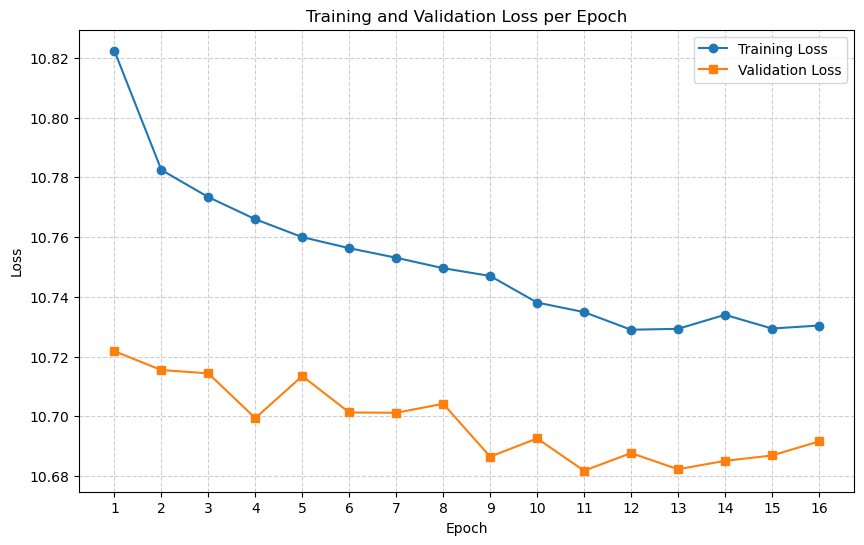

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Simulate training and validation loss data for 15 epochs
epochs = 16
training_loss = np.array([10.8224, 10.7825, 10.7734, 10.7660, 10.7600, 10.7563, 10.7531, 10.7496, 10.7470, 10.7381, 10.7349, 10.7290, 10.7293, 10.7340, 10.7294, 10.7304])
validation_loss = np.array([10.7218, 10.7155, 10.7144, 10.6994, 10.7135, 10.7013, 10.7012, 10.7042, 10.6865, 10.6926, 10.6818, 10.6877, 10.6823, 10.6851, 10.6869, 10.6916])


# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_loss, marker='o', label='Training Loss')
plt.plot(range(1, epochs + 1), validation_loss, marker='s', label='Validation Loss')

plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, epochs + 1))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

TASK 7

In [ ]:
#MLP Model

from calflops import calculate_flops # Import the function to calculate FLOPs, MACs, and parameters
from torchvision import models # Import pre-trained models from torchvision

batch_size = 16 # Define batch size for FLOP calculations: number of images processed at once
input_shape = (batch_size, 3, 224, 224) # Define input shape based on the batch size, number of channels (3 for RGB), and image dimensions (224x224)
# Compute FLOPs (Floating Point Operations), MACs (Multiply-Accumulate Operations), and total parameters
flops, macs, params = calculate_flops(model=oop_model, # Model being analyzed
                                      input_shape=input_shape, # Input shape of the data
                                      output_as_string=True, # Format output as readable strings
                                      output_precision=4) # Precision for numerical output
print("Alexnet FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))

In [13]:
# Define the CNN Model class inheriting from nn.Module
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()  # Call the parent class's constructor

        # Define the layers of the CNN
        # Convolutional Layer 1: 16 filters, kernel size 3x3, stride 1, padding 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()  # ReLU activation for Conv1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2 Max Pooling Layer

        # Convolutional Layer 2: 32 filters, kernel size 3x3, stride 1, padding 1
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()  # ReLU activation for Conv2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2 Max Pooling Layer

        # Convolutional Layer 3: 64 filters, kernel size 3x3, stride 1, padding 1
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()  # ReLU activation for Conv3
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2 Max Pooling Layer

        # Fully connected layer: input size depends on flattened dimensions, output size is 80
        self.fc = nn.Linear(64 * 28 * 28, 90)  # Calculate 28*28 from the input size (224x224) after 3 pooling layers

        # Output activation function
        self.sigmoid = nn.Sigmoid()

    # Define the forward pass
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = self.fc(x)  # Fully connected layer

        return self.sigmoid(x)  # Sigmoid activation for multi-label classification

# Instantiate the CNN model
cnn_model = CustomCNN().to(device)  # Move the model to the device (GPU/CPU)

In [ ]:
#CNN Model

from calflops import calculate_flops # Import the function to calculate FLOPs, MACs, and parameters
from torchvision import models # Import pre-trained models from torchvision

batch_size = 16 # Define batch size for FLOP calculations: number of images processed at once
input_shape = (batch_size, 3, 224, 224) # Define input shape based on the batch size, number of channels (3 for RGB), and image dimensions (224x224)
# Compute FLOPs (Floating Point Operations), MACs (Multiply-Accumulate Operations), and total parameters
flops, macs, params = calculate_flops(model=cnn_model, # Model being analyzed
                                      input_shape=input_shape, # Input shape of the data
                                      output_as_string=True, # Format output as readable strings
                                      output_precision=4) # Precision for numerical output
print("Alexnet FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))

In [ ]:
# ResNet50 model (Not Pretrained) for multi-label classification
class ResNet50(nn.Module):
    def __init__(self, num_classes=80, weights=None):
        super(ResNet50, self).__init__()
        self.resnet = models.resnet50(weights=weights) # Load ResNet50 with weights
        self.resnet.fc = nn.Linear(2048, 80) # Replace the last fully connected layer with a new one for multi-label classification
        self.sigmoid = nn.Sigmoid() # Sigmoid activation function for output

    def forward(self, x):
        x = self.resnet(x) # Forward pass through resnet
        x = self.sigmoid(x) # Apply sigmoid to output
        return x

#device = torch.device('cpu')
resNet50_model = ResNet50().to(device)

In [ ]:
#CNN Model

from calflops import calculate_flops # Import the function to calculate FLOPs, MACs, and parameters
from torchvision import models # Import pre-trained models from torchvision

batch_size = 16 # Define batch size for FLOP calculations: number of images processed at once
input_shape = (batch_size, 3, 224, 224) # Define input shape based on the batch size, number of channels (3 for RGB), and image dimensions (224x224)
# Compute FLOPs (Floating Point Operations), MACs (Multiply-Accumulate Operations), and total parameters
flops, macs, params = calculate_flops(model=resNet50_model, # Model being analyzed
                                      input_shape=input_shape, # Input shape of the data
                                      output_as_string=True, # Format output as readable strings
                                      output_precision=4) # Precision for numerical output
print("Alexnet FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
person
car
dog
handbag
tie
tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
   

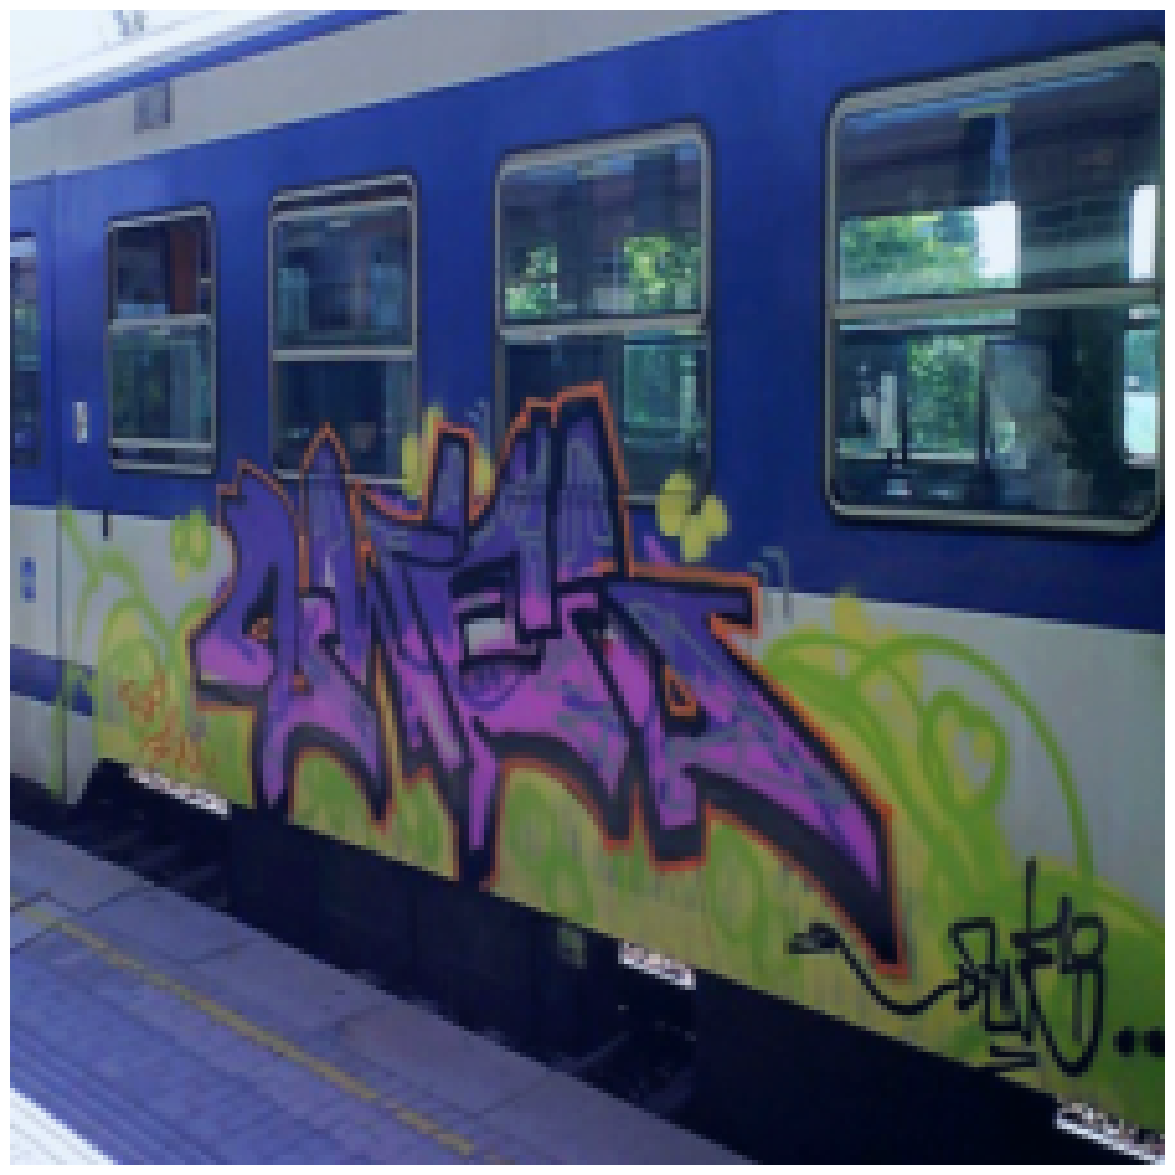

train


In [96]:
for batch_idx, (data, target) in enumerate(test_loader):
    print(batch_idx)
    if batch_idx == 15:
        break
    data, target = data.to(device), target.to(device)  # Move data and target to the appropriate device (GPU/CPU)
    # Forward pass: compute predicted outputs by passing data through the model
    output = pretrained_model(data)


output = torch.round(output)[0].detach().numpy()

print(output)


for i in range(len(classes)):
    if output[i] == 1:
        print(classes[i])


img_test, target_test = test_data.__getitem__(15)

print(target)
print(target_test)

print(img_test.size())

# Convert the tensor to a numpy array and rearrange to [H, W, C] for matplotlib
image_numpy = img_test.permute(1, 2, 0).numpy()

# Normalize the values to be between 0 and 1 for proper visualization
# (this step assumes the tensor values are between -1 and 1, adjust as needed)
image_numpy = (image_numpy - image_numpy.min()) / (image_numpy.max() - image_numpy.min())

# Plot the image
plt.imshow(image_numpy)
plt.axis('off')  # Turn off axis
plt.show()

target_test = target_test.numpy()

for i in range(len(classes)):
    if target_test[i] == 1:
        print(classes[i])
        

In [14]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()  # Call the parent class's constructor

        # Define the layers of the CNN
        # Convolutional Layer 1: 16 filters, kernel size 3x3, stride 1, padding 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()  # ReLU activation for Conv1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2 Max Pooling Layer

        # Convolutional Layer 2: 32 filters, kernel size 3x3, stride 1, padding 1
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()  # ReLU activation for Conv2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2 Max Pooling Layer

        # Convolutional Layer 3: 64 filters, kernel size 3x3, stride 1, padding 1
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()  # ReLU activation for Conv3
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2 Max Pooling Layer

        # Fully connected layer: input size depends on flattened dimensions, output size is 80
        self.fc = nn.Linear(64 * 28 * 28, 90)  # Calculate 28*28 from the input size (224x224) after 3 pooling layers

        # Output activation function
        self.sigmoid = nn.Sigmoid()

    # Define the forward pass
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = self.fc(x)  # Fully connected layer

        return self.sigmoid(x)  # Sigmoid activation for multi-label classification

cnn_model = CustomCNN().to(device)
cnn_model.load_state_dict(torch.load('model_checkpoint_epoch_15_cnn.pth', weights_only=True, map_location=torch.device('cpu'))['model_state_dict'])
cnn_model.eval()

CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=50176, out_features=90, bias=True)
  (sigmoid): Sigmoid()
)

In [15]:
# prepare to count predictions for each class
true_positive_cnn_model = {classname: 0 for classname in classes}
false_positive_cnn_model = {classname: 0 for classname in classes}
false_negative_cnn_model = {classname: 0 for classname in classes}
true_negative_cnn_model = {classname: 0 for classname in classes}


# again no gradients needed
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device) 

        output = cnn_model(data)

        target = target[0]
        #print(target)

        output = torch.round(output)
        output = output[0]
        #print(output)

        # collect the correct predictions for each class
        for index, (label, prediction) in enumerate(zip(target, output)):
            #print(label)
            #print(prediction)
            if label == prediction:
                #print('true')
                if prediction == 1.:
                    #print('positive')
                    true_positive_cnn_model[classes[index]] += 1
                else:
                    #print('negative')
                    true_negative_cnn_model[classes[index]] += 1
            else:
                if prediction == 1:
                    false_positive_cnn_model[classes[index]] += 1
                else:
                    false_negative_cnn_model[classes[index]] += 1

In [17]:
cat = 'chair'

tp_rn = true_positive_cnn_model[cat]/(true_positive_cnn_model[cat]+false_negative_cnn_model[cat])
fn_rn= false_negative_cnn_model[cat]/(true_positive_cnn_model[cat]+false_negative_cnn_model[cat])
tn_rn = true_negative_cnn_model[cat]/(true_negative_cnn_model[cat]+false_positive_cnn_model[cat])
fp_rn = false_positive_cnn_model[cat]/(false_positive_cnn_model[cat]+true_negative_cnn_model[cat])

print(tp_rn)
print(fn_rn)
print(fp_rn)
print(tn_rn)

print(true_positive_cnn_model[cat])
print(false_negative_cnn_model[cat])
print(false_positive_cnn_model[cat])
print(true_negative_cnn_model[cat])

0.009774436090225564
0.9902255639097745
0.014761904761904763
0.9852380952380952
13
1317
155
10345


In [18]:
#Model Evaluation and Metrics RN Model
accuracy_RN= (true_positive_cnn_model[cat]+true_negative_cnn_model[cat])/(true_positive_cnn_model[cat]+true_negative_cnn_model[cat]+false_positive_cnn_model[cat]+false_negative_cnn_model[cat])
precision_RN = true_positive_cnn_model[cat]/(true_positive_cnn_model[cat]+false_positive_cnn_model[cat])
recall_RN = true_positive_cnn_model[cat]/(true_positive_cnn_model[cat]+false_negative_cnn_model[cat])
f1_RN = 2*(precision_RN*recall_RN)/(precision_RN+recall_RN)

print(accuracy_RN)
print(precision_RN)
print(recall_RN)
print(f1_RN)

0.875570583262891
0.07738095238095238
0.009774436090225564
0.017356475300400534
